
# **SimpleCNN**
The `SimpleCNN` class implements a Convolutional Neural Network (CNN) architecture designed for tasks that focus on mesoscopic image proporties, often used in image forensics, such as deepfake detection. This network is based on the principles of the **Meso-4** architecture, a variant of the original **MesoNet** proposed by Afchar et al.

## **Architecture Breakdown**
### **1. Convolutional Blocks**
Each block follows a consistent Pattern: **Convolution** &rarr; **Batch Normalization** &rarr; **ReLU Activation** &rarr; **Max Pooling**
|Block|Input Channels|Output Channels|Kernel Size|Max Pool Size|Output Size (HxW)|Purpose|
|---|---|---|---|---|---|---|
|**Block 1**|3|8|3x3|2x2|128x128|Initial feature extraction|
|**Block 2**|8|8|3x3|2x2|64x64|Further feature extraction|
|**Block 3**|8|16|5x5|2x2|32x32|Increased filter size of wider context|
|**Block 4**|16|16|5x5|2x2|16x16|Final feature map preparation|

* **Batch Normalization (`nn.BatchNorm2d`)**: used after each convolutiona to stablize and accelerate training.
* **Activation (`nn.ReLU`)**: The Rectified Linear Unit is used for non-linearity in the convolutional layers.

### **2. Classifier**
The convolutional feature maps are processed by a fully connected (FC) classifier.
- **Flatten**: The final 3D feature map (16 channels, 16x16 size) is flattened into a vector of size $16\times 16\times 16 = 4096$
- **Hidden Layer (`nn.Linear`)**: A fully connected layer maps the features to **16 units**.
- **Activation (`nn.LeakyReLU`)**: The Leaky ReLU (with a negative slope of 0.1) is used as the activation function for the hidden layer.
- **Regularization (`nn.Dropout`)**: A Dropout layer with $p=0.5$ is applied to prevent over fitting.
- **Output Layer (`nn.Layer`)**: The final fully connected layer maps the 16 units to the number of output classes (`num_classes`).

# **Training Process**

### **Import Libraries & Setup Configurations**

In [1]:
import torch
import torchsummary
import torch.nn as nn
import torch.optim as optim
import os
import sys

In [2]:
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
BASE_DIR = os.path.basename(project_root)

In [6]:
from src.dataloader import get_data_loaders
from src.model import SimpleCNN
from src.train import train_one_epoch, evaluate
from src.utils import set_seed, save_checkpoint, save_experiment_json, performance, get_device, error_analysis, plot_error_analysis

In [4]:
DATA_ROOT = '../data/'
RESULTS_DIR = '../results/simple-cnn'
MODEL_WEIGHTS = '../model_checkpoints/simple-cnn'
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODEL_WEIGHTS, exist_ok=True)

In [5]:
torch.backends.cudnn.benchmark = True
DEVICE = torch.device(get_device())
set_seed(42)

In [6]:
print(f"Base directory: {BASE_DIR}")
print(f"Device: {DEVICE}")

Base directory: deep_fake_detection
Device: cuda


## **Without Augmentation & Label Smoothing**

In [8]:
MODEL_NAME = "simpleCNN"
TASK_NAME = "no_aug"
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.001

In [10]:
train_loader, valid_loader, test_loader = get_data_loaders(
    DATA_ROOT, MODEL_NAME, BATCH_SIZE, use_augmentation=False)

In [11]:
model = SimpleCNN(num_classes=2).to(DEVICE)
torchsummary.summary(model, (3, 256, 256), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 8, 256, 256]             216
       BatchNorm2d-2          [32, 8, 256, 256]              16
              ReLU-3          [32, 8, 256, 256]               0
         MaxPool2d-4          [32, 8, 128, 128]               0
            Conv2d-5          [32, 8, 130, 130]             576
       BatchNorm2d-6          [32, 8, 130, 130]              16
              ReLU-7          [32, 8, 130, 130]               0
         MaxPool2d-8            [32, 8, 65, 65]               0
            Conv2d-9           [32, 16, 65, 65]           3,200
      BatchNorm2d-10           [32, 16, 65, 65]              32
             ReLU-11           [32, 16, 65, 65]               0
        MaxPool2d-12           [32, 16, 32, 32]               0
           Conv2d-13           [32, 16, 32, 32]           6,400
      BatchNorm2d-14           [32, 16,

In [12]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [13]:
history = {
    'model_name': MODEL_NAME,
    'EPOCHS': EPOCHS,
    'model_saved_path': '',
    'train_losses': [],
    'valid_losses': [],
    'train_accuracy': [],
    'valid_accuracy': [],
    'valid_f1': [],
    'valid_auc': [],
    'best_accuracy': [],
    'best_epoch': [],
}

In [14]:
best_acc = 0.0

for epoch in range(EPOCHS):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Metrics record
    history['train_losses'].append(train_loss)
    history['valid_losses'].append(valid_loss)
    history['train_accuracy'].append(train_acc)
    history['valid_accuracy'].append(valid_acc)
    history['valid_f1'].append(valid_f1)
    history['valid_auc'].append(valid_auc)
    
    # Save best model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history['best_accuracy'] = best_acc
        history['best_epoch'] = epoch + 1
        history['model_saved_path'] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


[1/30] train_acc: 0.5602 - train_loss: 0.6879 - valid_acc: 0.6107 - valid_loss: 0.6492
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 1 - acc: 0.6107



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.84it/s]


[2/30] train_acc: 0.6032 - train_loss: 0.6593 - valid_acc: 0.6282 - valid_loss: 0.6395
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 2 - acc: 0.6282



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.81it/s]


[3/30] train_acc: 0.6250 - train_loss: 0.6418 - valid_acc: 0.6359 - valid_loss: 0.6419
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 3 - acc: 0.6359



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.30it/s]


[4/30] train_acc: 0.6323 - train_loss: 0.6295 - valid_acc: 0.6463 - valid_loss: 0.6287
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 4 - acc: 0.6463



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.27it/s]


[5/30] train_acc: 0.6501 - train_loss: 0.6121 - valid_acc: 0.6567 - valid_loss: 0.6062
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 5 - acc: 0.6567



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.35it/s]


[6/30] train_acc: 0.6674 - train_loss: 0.5957 - valid_acc: 0.6500 - valid_loss: 0.6121
	- [current best] epoch: 5 - acc: 0.6567



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.10it/s]


[7/30] train_acc: 0.6800 - train_loss: 0.5771 - valid_acc: 0.6661 - valid_loss: 0.6079
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 7 - acc: 0.6661



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.06it/s]


[8/30] train_acc: 0.6934 - train_loss: 0.5641 - valid_acc: 0.6779 - valid_loss: 0.6009
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 8 - acc: 0.6779



Evaluating: 100%|██████████| 94/94 [00:18<00:00,  5.03it/s]


[9/30] train_acc: 0.7084 - train_loss: 0.5433 - valid_acc: 0.6799 - valid_loss: 0.6202
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 9 - acc: 0.6799



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.14it/s]


[10/30] train_acc: 0.7236 - train_loss: 0.5241 - valid_acc: 0.6792 - valid_loss: 0.6148
	- [current best] epoch: 9 - acc: 0.6799



Evaluating: 100%|██████████| 94/94 [00:16<00:00,  5.55it/s]


[11/30] train_acc: 0.7308 - train_loss: 0.5135 - valid_acc: 0.6768 - valid_loss: 0.6206
	- [current best] epoch: 9 - acc: 0.6799



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.42it/s]


[12/30] train_acc: 0.7416 - train_loss: 0.4955 - valid_acc: 0.6809 - valid_loss: 0.6228
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 12 - acc: 0.6809



Evaluating: 100%|██████████| 94/94 [00:17<00:00,  5.29it/s]


[13/30] train_acc: 0.7567 - train_loss: 0.4757 - valid_acc: 0.6977 - valid_loss: 0.6463
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 13 - acc: 0.6977



Evaluating: 100%|██████████| 94/94 [00:18<00:00,  5.22it/s]


[14/30] train_acc: 0.7665 - train_loss: 0.4620 - valid_acc: 0.6856 - valid_loss: 0.6017
	- [current best] epoch: 13 - acc: 0.6977



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.27it/s]


[15/30] train_acc: 0.7772 - train_loss: 0.4432 - valid_acc: 0.6815 - valid_loss: 0.6740
	- [current best] epoch: 13 - acc: 0.6977



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.60it/s]


[16/30] train_acc: 0.7869 - train_loss: 0.4271 - valid_acc: 0.6980 - valid_loss: 0.6843
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 16 - acc: 0.6980



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.20it/s]


[17/30] train_acc: 0.7965 - train_loss: 0.4164 - valid_acc: 0.6930 - valid_loss: 0.6953
	- [current best] epoch: 16 - acc: 0.6980



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.55it/s]


[18/30] train_acc: 0.8073 - train_loss: 0.4002 - valid_acc: 0.6916 - valid_loss: 0.6998
	- [current best] epoch: 16 - acc: 0.6980



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.69it/s]


[19/30] train_acc: 0.8125 - train_loss: 0.3877 - valid_acc: 0.6889 - valid_loss: 0.7436
	- [current best] epoch: 16 - acc: 0.6980



Evaluating: 100%|██████████| 94/94 [00:13<00:00,  7.05it/s]


[20/30] train_acc: 0.8192 - train_loss: 0.3766 - valid_acc: 0.6708 - valid_loss: 0.8477
	- [current best] epoch: 16 - acc: 0.6980



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.66it/s]


[21/30] train_acc: 0.8284 - train_loss: 0.3586 - valid_acc: 0.7013 - valid_loss: 0.7958
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 21 - acc: 0.7013



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.16it/s]


[22/30] train_acc: 0.8363 - train_loss: 0.3456 - valid_acc: 0.7084 - valid_loss: 0.6977
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 22 - acc: 0.7084



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.18it/s]


[23/30] train_acc: 0.8388 - train_loss: 0.3402 - valid_acc: 0.6886 - valid_loss: 0.8565
	- [current best] epoch: 22 - acc: 0.7084



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.73it/s]


[24/30] train_acc: 0.8448 - train_loss: 0.3272 - valid_acc: 0.6903 - valid_loss: 0.9853
	- [current best] epoch: 22 - acc: 0.7084



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.68it/s]


[25/30] train_acc: 0.8512 - train_loss: 0.3179 - valid_acc: 0.7003 - valid_loss: 0.8398
	- [current best] epoch: 22 - acc: 0.7084



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.16it/s]


[26/30] train_acc: 0.8574 - train_loss: 0.3062 - valid_acc: 0.7097 - valid_loss: 0.8551
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 26 - acc: 0.7097



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.12it/s]


[27/30] train_acc: 0.8616 - train_loss: 0.2961 - valid_acc: 0.6826 - valid_loss: 1.0045
	- [current best] epoch: 26 - acc: 0.7097



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.83it/s]


[28/30] train_acc: 0.8689 - train_loss: 0.2842 - valid_acc: 0.6903 - valid_loss: 0.9636
	- [current best] epoch: 26 - acc: 0.7097



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.71it/s]


[29/30] train_acc: 0.8712 - train_loss: 0.2814 - valid_acc: 0.6893 - valid_loss: 1.0893
	- [current best] epoch: 26 - acc: 0.7097



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.01it/s]

[30/30] train_acc: 0.8741 - train_loss: 0.2737 - valid_acc: 0.7138 - valid_loss: 0.8432
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_no_aug.pth
	- [current best] epoch: 30 - acc: 0.7138



In [15]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}.pth"
save_checkpoint(model, optimizer, save_name)

Checkpoint saved: ../model_checkpoints/simple-cnn/simpleCNN_no_aug.pth


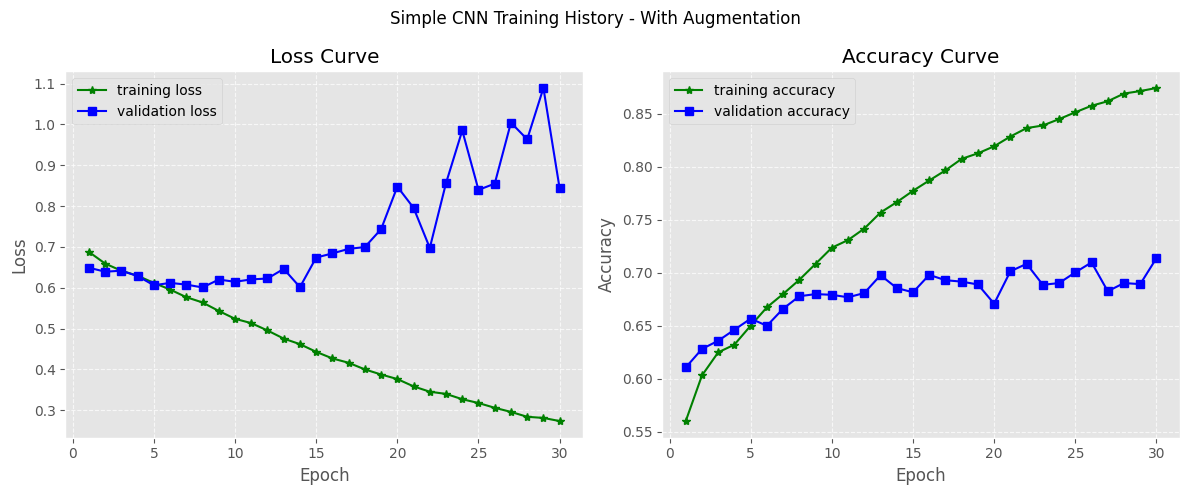

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History - With Augmentation")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["valid_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["valid_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [ ]:
json_filename = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/simple-cnn/simpleCNN_no_aug.json


Getting predictions: 100%|██████████| 95/95 [01:11<00:00,  1.33it/s]

Accuracy score: 0.6924
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1510
           1       0.69      0.69      0.69      1510

    accuracy                           0.69      3020
   macro avg       0.69      0.69      0.69      3020
weighted avg       0.69      0.69      0.69      3020



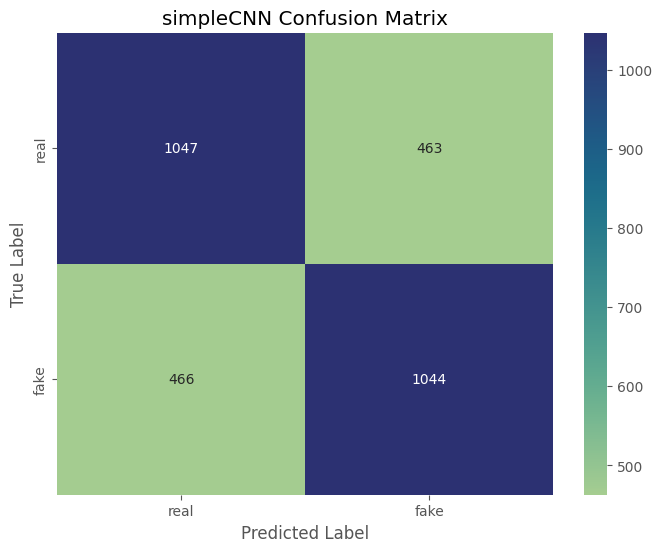

In [18]:
performance(model, test_loader, DEVICE, MODEL_NAME, TASK_NAME, RESULTS_DIR)

In [12]:
save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}.pth"
checkpoint = torch.load(save_name, map_location='cpu')
model.load_state_dict(checkpoint["state_dict"])
model = model.to(device=DEVICE)

Deepfakes : 0.8079
Face2Face : 0.7152
FaceSwap : 0.6225
FaceShifter : 0.8079
NeuralTextures : 0.5000


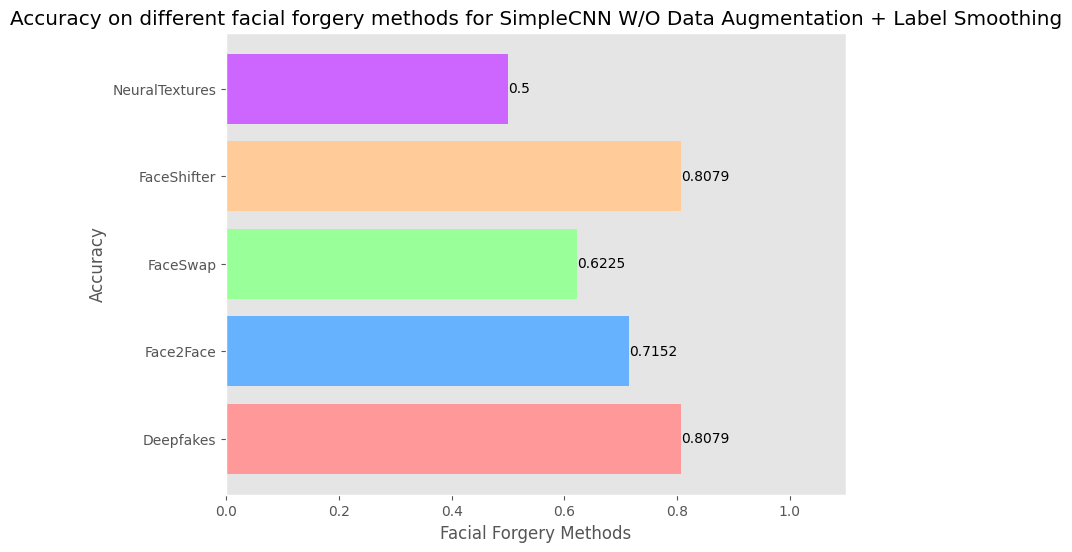

In [13]:
summary = error_analysis(model = model, fake_image_path = f"{project_root}/data/test/fake", model_name = MODEL_NAME, device = DEVICE)
plot_error_analysis(summary, model_name = "SimpleCNN W/O Data Augmentation + Label Smoothing")

## **With Augmentation + Label Smoothing**

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
MODEL_NAME = "simpleCNN"
TASK_NAME = "with_aug"
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.001

In [9]:
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

In [10]:
train_loader, valid_loader, test_loader = get_data_loaders(
    DATA_ROOT, MODEL_NAME, BATCH_SIZE, use_augmentation=True)

In [11]:
model = SimpleCNN(num_classes=2).to(DEVICE)
torchsummary.summary(model, (3, 256, 256), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 8, 256, 256]             216
       BatchNorm2d-2          [32, 8, 256, 256]              16
              ReLU-3          [32, 8, 256, 256]               0
         MaxPool2d-4          [32, 8, 128, 128]               0
            Conv2d-5          [32, 8, 130, 130]             576
       BatchNorm2d-6          [32, 8, 130, 130]              16
              ReLU-7          [32, 8, 130, 130]               0
         MaxPool2d-8            [32, 8, 65, 65]               0
            Conv2d-9           [32, 16, 65, 65]           3,200
      BatchNorm2d-10           [32, 16, 65, 65]              32
             ReLU-11           [32, 16, 65, 65]               0
        MaxPool2d-12           [32, 16, 32, 32]               0
           Conv2d-13           [32, 16, 32, 32]           6,400
      BatchNorm2d-14           [32, 16,

In [12]:
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [13]:
history_aug = {
    'model_name': MODEL_NAME,
    'EPOCHS': EPOCHS,
    'model_saved_path': '',
    'weight_decay': WEIGHT_DECAY,
    'label_smoothing': LABEL_SMOOTHING,
    'train_losses': [],
    'valid_losses': [],
    'train_accuracy': [],
    'valid_accuracy': [],
    'valid_f1': [],
    'valid_auc': [],
    'best_accuracy': [],
    'best_epoch': [],
}

In [15]:
best_acc = 0.0

for epoch in range(EPOCHS):
    # Train & Evaluate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Metrics record
    history_aug['train_losses'].append(train_loss)
    history_aug['valid_losses'].append(valid_loss)
    history_aug['train_accuracy'].append(train_acc)
    history_aug['valid_accuracy'].append(valid_acc)
    history_aug['valid_f1'].append(valid_f1)
    history_aug['valid_auc'].append(valid_auc)
    
    # Save best model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history_aug['best_accuracy'] = best_acc
        history_aug['best_epoch'] = epoch + 1
        history_aug['model_saved_path'] = save_name
        
    print(f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.94it/s]


[1/30] train_acc: 0.6158 - train_loss: 0.6656 - valid_acc: 0.5815 - valid_loss: 0.6769
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_with_aug.pth
	- [current best] epoch: 1 - acc: 0.5815



Evaluating: 100%|██████████| 94/94 [00:09<00:00,  9.53it/s]


[2/30] train_acc: 0.6171 - train_loss: 0.6647 - valid_acc: 0.6305 - valid_loss: 0.6548
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_with_aug.pth
	- [current best] epoch: 2 - acc: 0.6305



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.29it/s]


[3/30] train_acc: 0.6182 - train_loss: 0.6633 - valid_acc: 0.6248 - valid_loss: 0.6578
	- [current best] epoch: 2 - acc: 0.6305



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.03it/s]


[4/30] train_acc: 0.6227 - train_loss: 0.6597 - valid_acc: 0.6252 - valid_loss: 0.6570
	- [current best] epoch: 2 - acc: 0.6305



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


[5/30] train_acc: 0.6204 - train_loss: 0.6600 - valid_acc: 0.6252 - valid_loss: 0.6506
	- [current best] epoch: 2 - acc: 0.6305



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.55it/s]


[6/30] train_acc: 0.6248 - train_loss: 0.6577 - valid_acc: 0.5705 - valid_loss: 0.6779
	- [current best] epoch: 2 - acc: 0.6305



Evaluating: 100%|██████████| 94/94 [00:09<00:00,  9.63it/s]


[7/30] train_acc: 0.6274 - train_loss: 0.6572 - valid_acc: 0.6289 - valid_loss: 0.6505
	- [current best] epoch: 2 - acc: 0.6305



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.33it/s]


[8/30] train_acc: 0.6241 - train_loss: 0.6570 - valid_acc: 0.6201 - valid_loss: 0.6569
	- [current best] epoch: 2 - acc: 0.6305



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.10it/s]


[9/30] train_acc: 0.6242 - train_loss: 0.6586 - valid_acc: 0.6339 - valid_loss: 0.6554
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_with_aug.pth
	- [current best] epoch: 9 - acc: 0.6339



Evaluating: 100%|██████████| 94/94 [00:09<00:00,  9.51it/s]


[10/30] train_acc: 0.6285 - train_loss: 0.6577 - valid_acc: 0.6423 - valid_loss: 0.6521
Checkpoint saved: ../model_checkpoints/simple-cnn/best_simpleCNN_with_aug.pth
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  9.33it/s]


[11/30] train_acc: 0.6264 - train_loss: 0.6576 - valid_acc: 0.6248 - valid_loss: 0.6546
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:09<00:00,  9.46it/s]


[12/30] train_acc: 0.6269 - train_loss: 0.6578 - valid_acc: 0.6285 - valid_loss: 0.6534
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


[13/30] train_acc: 0.6267 - train_loss: 0.6552 - valid_acc: 0.6332 - valid_loss: 0.6539
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


[14/30] train_acc: 0.6282 - train_loss: 0.6551 - valid_acc: 0.6168 - valid_loss: 0.6566
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.58it/s]


[15/30] train_acc: 0.6267 - train_loss: 0.6543 - valid_acc: 0.6326 - valid_loss: 0.6539
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.17it/s]


[16/30] train_acc: 0.6311 - train_loss: 0.6543 - valid_acc: 0.6356 - valid_loss: 0.6550
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.08it/s]


[17/30] train_acc: 0.6257 - train_loss: 0.6551 - valid_acc: 0.6312 - valid_loss: 0.6481
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


[18/30] train_acc: 0.6299 - train_loss: 0.6550 - valid_acc: 0.6242 - valid_loss: 0.6519
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


[19/30] train_acc: 0.6293 - train_loss: 0.6559 - valid_acc: 0.6366 - valid_loss: 0.6504
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


[20/30] train_acc: 0.6294 - train_loss: 0.6551 - valid_acc: 0.6342 - valid_loss: 0.6503
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.36it/s]


[21/30] train_acc: 0.6274 - train_loss: 0.6550 - valid_acc: 0.6218 - valid_loss: 0.6536
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.49it/s]


[22/30] train_acc: 0.6273 - train_loss: 0.6559 - valid_acc: 0.6362 - valid_loss: 0.6511
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


[23/30] train_acc: 0.6295 - train_loss: 0.6548 - valid_acc: 0.6356 - valid_loss: 0.6530
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.95it/s]


[24/30] train_acc: 0.6264 - train_loss: 0.6548 - valid_acc: 0.6030 - valid_loss: 0.6666
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.18it/s]


[25/30] train_acc: 0.6270 - train_loss: 0.6537 - valid_acc: 0.6262 - valid_loss: 0.6629
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.78it/s]


[26/30] train_acc: 0.6289 - train_loss: 0.6549 - valid_acc: 0.6315 - valid_loss: 0.6520
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:09<00:00,  9.46it/s]


[27/30] train_acc: 0.6300 - train_loss: 0.6555 - valid_acc: 0.6252 - valid_loss: 0.6534
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:09<00:00,  9.43it/s]


[28/30] train_acc: 0.6311 - train_loss: 0.6537 - valid_acc: 0.6174 - valid_loss: 0.6607
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.87it/s]


[29/30] train_acc: 0.6308 - train_loss: 0.6519 - valid_acc: 0.6295 - valid_loss: 0.6505
	- [current best] epoch: 10 - acc: 0.6423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  7.98it/s]

[30/30] train_acc: 0.6287 - train_loss: 0.6532 - valid_acc: 0.6154 - valid_loss: 0.6644
	- [current best] epoch: 10 - acc: 0.6423



In [16]:
save_name = f"{MODEL_WEIGHTS}/{MODEL_NAME}_{TASK_NAME}.pth"
save_checkpoint(model, optimizer, save_name)

Checkpoint saved: ../model_checkpoints/simple-cnn/simpleCNN_with_aug.pth


In [17]:
json_filename = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history_aug, json_filename)

History saved to ../results/simple-cnn/simpleCNN_with_aug.json


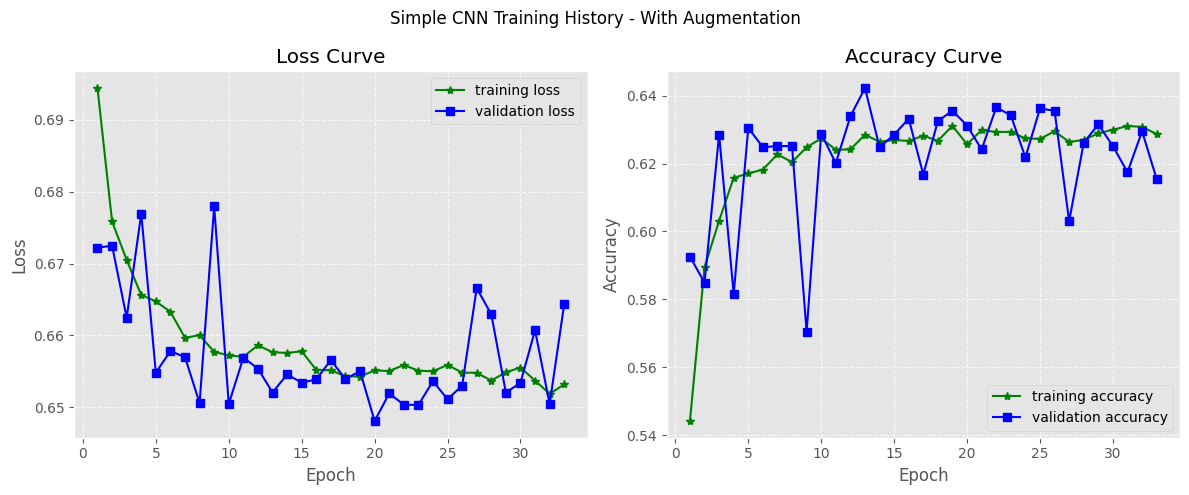

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history_aug["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History - With Augmentation")

ax[0].plot(epochs, history_aug["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history_aug["valid_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history_aug["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history_aug["valid_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

Getting predictions: 100%|██████████| 95/95 [00:56<00:00,  1.68it/s]

Accuracy score: 0.6149
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.72      0.65      1510
           1       0.65      0.51      0.57      1510

    accuracy                           0.61      3020
   macro avg       0.62      0.61      0.61      3020
weighted avg       0.62      0.61      0.61      3020



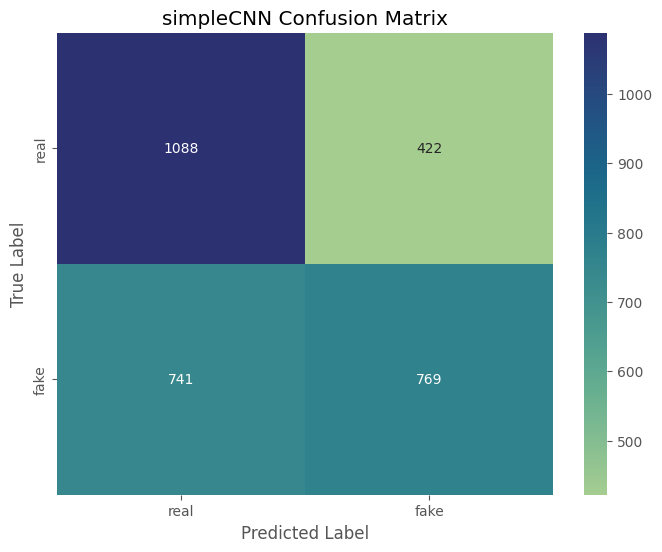

In [19]:
performance(model, test_loader, DEVICE, MODEL_NAME, TASK_NAME, RESULTS_DIR)

In [16]:
save_name = f"{MODEL_WEIGHTS}/best_{MODEL_NAME}_{TASK_NAME}.pth"
checkpoint = torch.load(save_name, map_location='cpu')
model.load_state_dict(checkpoint["state_dict"])
model = model.to(device=DEVICE)


Deepfakes : 0.8212
Face2Face : 0.6556
FaceSwap : 0.5728
FaceShifter : 0.8377
NeuralTextures : 0.5497


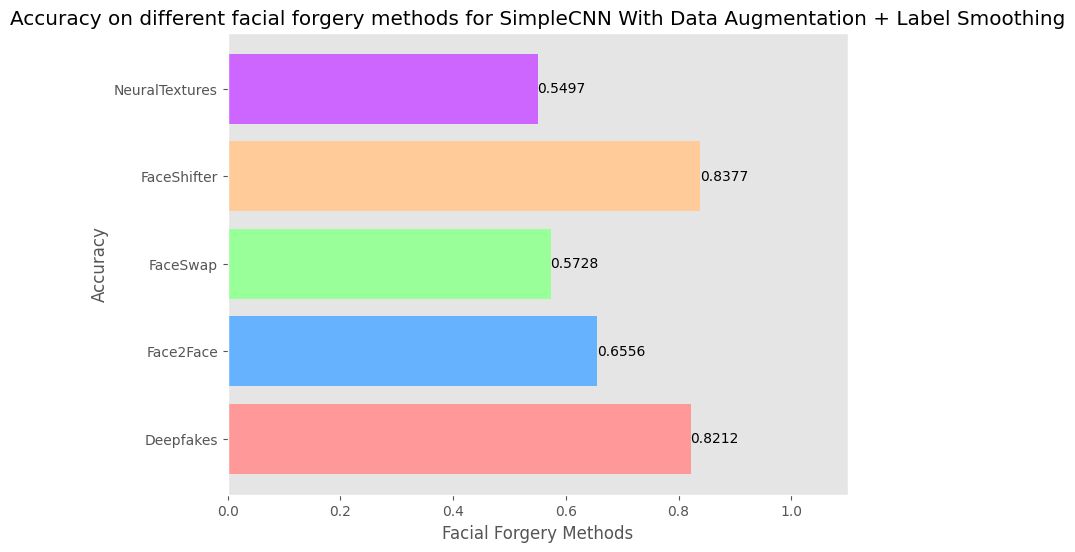

In [ ]:
summary = error_analysis(model = model, fake_image_path = f"{project_root}/data/test/fake", model_name = MODEL_NAME, device = DEVICE)


In [21]:
def plot_error_analysis(summary, model_name, save_path=None):
    import matplotlib.pyplot as plt
    methods = list(summary.keys())
    values = [round(summary[method]['correct_pred']/summary[method]['total'], 4) for method in methods]
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#CC66FF'] 
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.barh(methods, values, color=colors)
    ax.bar_label(bars)
    plt.xlabel('Facial Forgery Methods')
    plt.ylabel('Accuracy')
    plt.xlim(0, 1.1)
    plt.title(f'Accuracy on different facial forgery methods for {model_name}')
    plt.grid(False)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

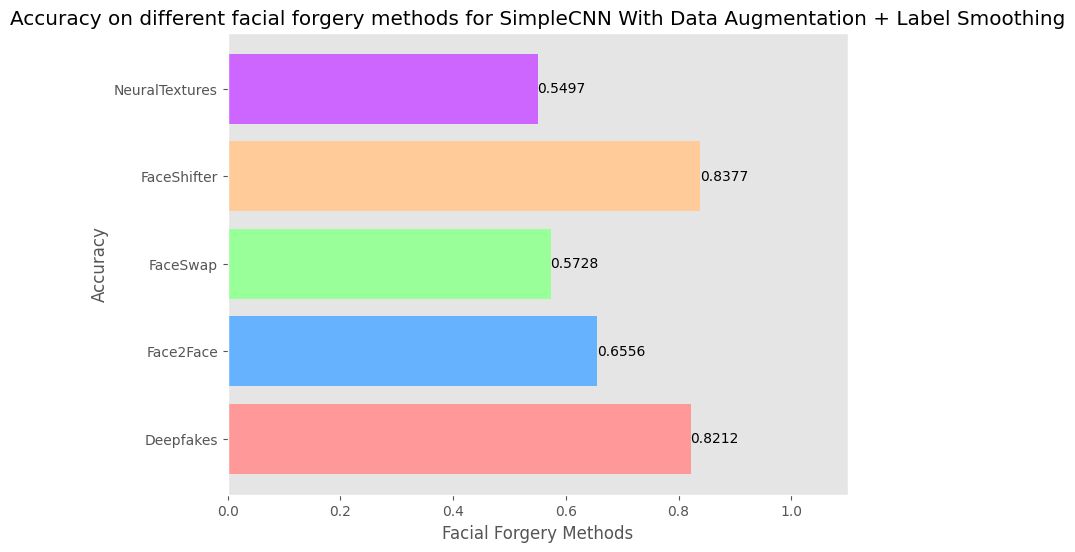

In [22]:
error_save_path = f"{RESULTS_DIR}/{MODEL_NAME}_{TASK_NAME}_error_analysis.png"
plot_error_analysis(summary, model_name = "SimpleCNN With Data Augmentation + Label Smoothing", save_path = error_save_path)